In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Get_groups import phase_diagram,make_meanr

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import parmap
from pprint import pprint

In [ ]:
seed =10
N = 1000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 7
dt = 0.1
t = np.arange(0,10000,dt)
K = 5
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta= np.random.uniform(-1,1,N),p_omega=omega)
# new_theta = to_ppi(theta)
# dtheta_c = np.cumsum(dtheta,axis=0)
# sum_time = 200
# avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
# plt.plot(np.sort(avg_dtheta[-1]))
# plt.plot((avg_dtheta[-1]))

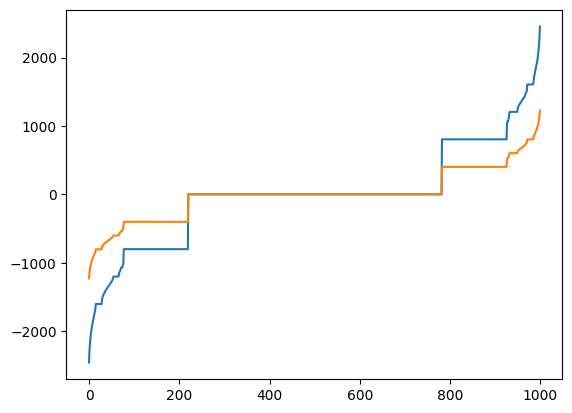

In [ ]:
ARG = (theta[-1]-theta[-len(t)//4])//np.pi
plt.plot(ARG)
ARG = (theta[-1]-theta[-len(t)//8])//np.pi
plt.plot(ARG)


In [ ]:
ARG = (theta[-1]-theta[-len(t)//8])//np.pi
ARG =  np.where(ARG<0,ARG,ARG+1)
u,c = np.unique(ARG,return_counts=True)

I_c_o1 =np.where(c>1)
u_o1 = u[I_c_o1]
c_o1 = c[I_c_o1]
u_c = np.argsort(c_o1)[::-1]
UU = u_o1[u_c]
R_M = UU[0]
R_WR = UU - R_M
RU = np.abs(R_WR)
G_L = []
for G in set(RU):
    print(G)


0.0
803.0
804.0
401.0
402.0
403.0
537.0
602.0
603.0
702.0


54.0
-1.0
1.0
3.0
5.0


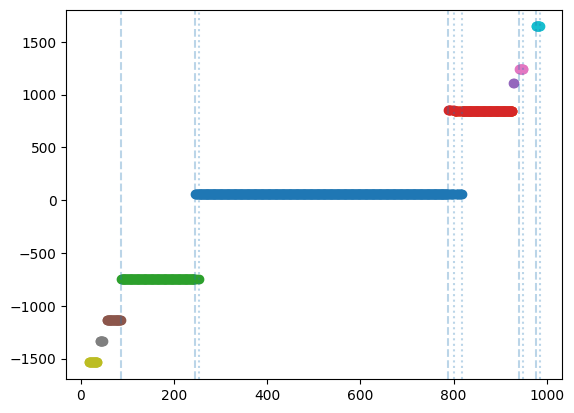

In [ ]:
ARG = (theta[-1]-theta[-len(t)//4])//np.pi
ARG =  np.where(ARG<0,ARG,ARG+1)
u,c = np.unique(ARG,return_counts=True)

I_c_o1 =np.where(c>1)
u_o1 = u[I_c_o1]
c_o1 = c[I_c_o1]
u_c = np.argsort(c_o1) 
UU = u_o1[u_c][::-1]
R_M = UU[0]
R_WR = UU - R_M
np.abs(R_WR) 
R_WR_C = np.argsort(np.abs(R_WR))
R_MM,R_old = 0,0
G_num = 0
G = {}
print(R_WR[R_WR_C][0]+R_M)
I, = np.where(ARG == R_WR[R_WR_C][0]+R_M)
G[0,'I'] = I
G[0,'R'] = R_M
plt.scatter(G[0,'I'],ARG[G[0,'I']])
plt.axvline(max(I),ls=':',alpha=0.3)
plt.axvline(min(I),ls='--',alpha=0.3)
keys = [0]
Rs = []

for R in R_WR[R_WR_C][1:]:
    if abs(abs(R) - abs(R_MM))<10:
        I, = np.where(ARG == R+R_M)
        G[0,'I'] = np.r_[G[0,'I'],I]
        plt.scatter(G[0,'I'],ARG[G[0,'I']])
    else:
        if abs(abs(R)-abs(R_old))<10:
            Gs = np.sign(R)*G_num
            I, = np.where(ARG == R+R_M)
            if Gs in keys:
                G[Gs,'I'] = np.r_[G[Gs,'I'],I]
            else:
                G[Gs,'I'] =  I
            G[Gs,'R'] = R_M + R
            keys.append(Gs)
            print(Gs)
            plt.scatter(G[Gs,'I'],ARG[G[Gs,'I']])
            plt.axvline(max(I),ls=':',alpha=0.3)
            plt.axvline(min(I),ls='--',alpha=0.3)
            R_old = R
        else:
            G_num += 1
            I, = np.where(ARG == R+R_M)
            Gs = np.sign(R)*G_num
            keys.append(Gs)
            G[Gs,'I'] = I
            G[Gs,'R'] = R_M + R
            # print(Gs)
            plt.scatter(G[Gs,'I'],ARG[G[Gs,'I']])

    R_old = R
    # print(I)
    # plt.scatter(I,ARG[I])
